<a href="https://colab.research.google.com/github/miketriana/cap4630-wocjan/blob/master/HW_4/HW4_3A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Homework 4 Problem 3 - A

For this problem I will be modifying the code from https://colab.research.google.com/drive/1F-RWvoxH8MmT7c1UmNy41iuOp-ejiLoF?authuser=1 to use a different conv base.

In this example I will replace the VGG16 conv base from the original notebook with the Xception conv base.

##Download the data

In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2020-04-21 03:06:15--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.128, 2404:6800:4003:c03::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  90.1MB/s    in 0.7s    

2020-04-21 03:06:16 (90.1 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

##Build the network

I will use the Xception convolution base to build the network.

In [4]:
# VGG16 Conv base replaced with ResNet50
from keras.applications.xception import Xception

conv_base = Xception(
    weights='imagenet', 
    include_top=False, 
    input_shape=(150, 150, 3))

Using TensorFlow backend.


83689472/83683744 [==============================] - 8s 0us/step


In [5]:
conv_base.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 74, 74, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 74, 74, 32)   0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

The convolutional base is frozen so that it will not be trained along with the rest of the model.

In [0]:
conv_base.trainable = False

Then, several fully connected layers are concatenated onto the model.

In [0]:
from keras import layers
from keras import models
from keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
#model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))

In [8]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 5, 5, 2048)        20861480  
_________________________________________________________________
flatten_1 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               13107456  
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 33,969,193
Trainable params: 13,107,713
Non-trainable params: 20,861,480
_________________________________________________________________


##Train the model

In [9]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

# data augmentation

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

# compile model

model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizers.RMSprop(lr=2e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 29s 290ms/step - loss: 0.4449 - acc: 0.7790 - val_loss: 0.0214 - val_acc: 0.9610
Epoch 2/30
100/100 [==============================] - 19s 190ms/step - loss: 0.3877 - acc: 0.8135 - val_loss: 0.0388 - val_acc: 0.9670
Epoch 3/30
100/100 [==============================] - 19s 191ms/step - loss: 0.3461 - acc: 0.8420 - val_loss: 0.0819 - val_acc: 0.9670
Epoch 4/30
100/100 [==============================] - 19s 190ms/step - loss: 0.3378 - acc: 0.8550 - val_loss: 0.1147 - val_acc: 0.9600
Epoch 5/30
100/100 [==============================] - 19s 193ms/step - loss: 0.3405 - acc: 0.8545 - val_loss: 0.0034 - val_acc: 0.9690
Epoch 6/30
100/100 [==============================] - 19s 189ms/step - loss: 0.3179 - acc: 0.8535 - val_loss: 0.4567 - val_acc: 0.9730
Epoch 7/30
100/100 [==============================] - 19s 190ms/step - loss: 0.3111 - acc: 0.8620 - val_lo

##Display loss and accuracy

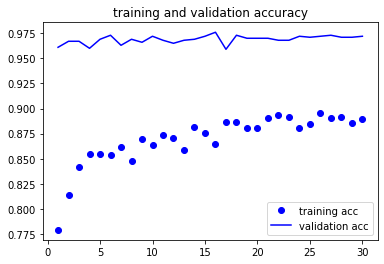

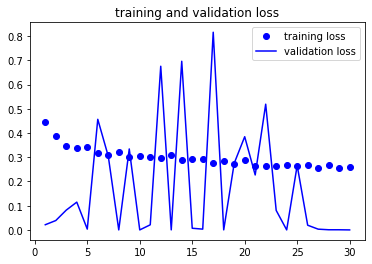

In [10]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

##Fine tuning

To fine tune the model, I will unfreeze some of the layers in the conv base and retrain. The best results should come from unfreezing layers close to the top, so I will only unfreeze layers from block 12 and up.

In [0]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block12_sepconv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

In [12]:
# compile model

model.compile(
    loss='binary_crossentropy',
    #
    # choose a smaller learning rate
    #
    optimizer=optimizers.RMSprop(lr=1e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/100
100/100 [==============================] - 25s 255ms/step - loss: 0.2745 - acc: 0.8910 - val_loss: 0.0314 - val_acc: 0.9610
Epoch 2/100
100/100 [==============================] - 21s 205ms/step - loss: 0.2493 - acc: 0.8995 - val_loss: 0.0228 - val_acc: 0.9370
Epoch 3/100
100/100 [==============================] - 20s 204ms/step - loss: 0.2185 - acc: 0.9100 - val_loss: 0.2130 - val_acc: 0.9400
Epoch 4/100
100/100 [==============================] - 21s 207ms/step - loss: 0.2207 - acc: 0.9195 - val_loss: 0.0957 - val_acc: 0.9370
Epoch 5/100
100/100 [==============================] - 20s 203ms/step - loss: 0.2271 - acc: 0.9090 - val_loss: 0.8551 - val_acc: 0.9310
Epoch 6/100
100/100 [==============================] - 20s 205ms/step - loss: 0.1980 - acc: 0.9165 - val_loss: 0.2114 - val_acc: 0.9360
Epoch 7/100
100/100 [==============================] - 21s 205ms/step - loss: 0.2009 - acc: 0.9175 - val_loss: 0.2275 - val_acc: 0.9290
Epoch 8/100
100/100 [===========================

##Display learning curves during fine tuning

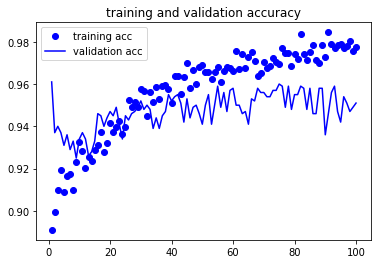

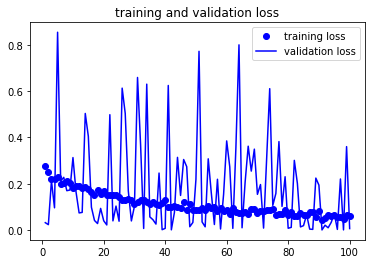

In [13]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()